# Udacity Advance Lane Lines Project

In [4]:
# Place for adding all includes
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML


%matplotlib inline

Total number of images: 20


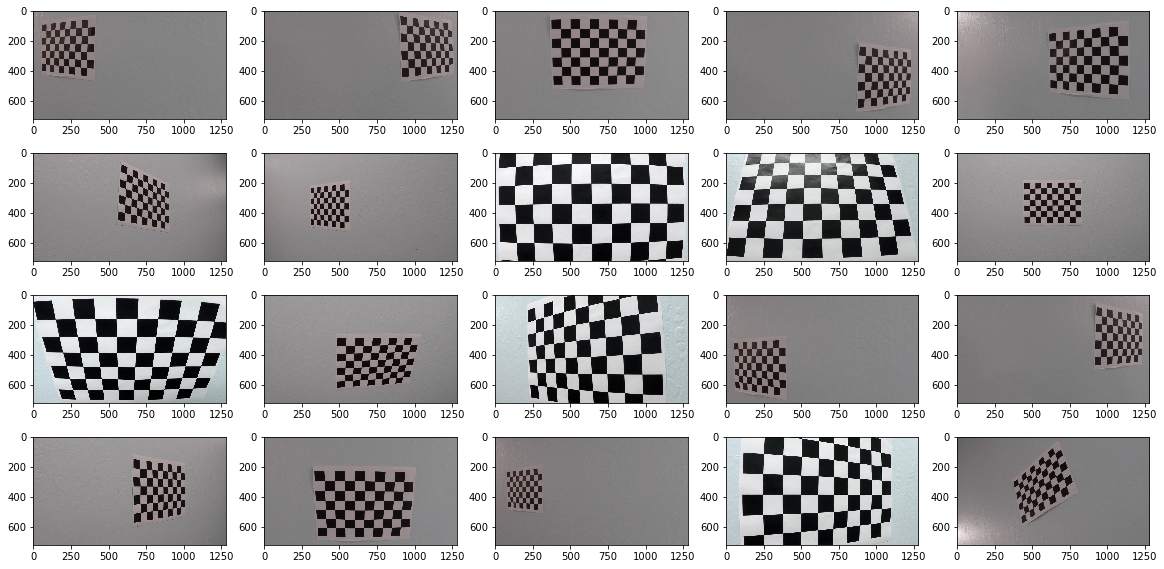

In [16]:
# Try to plot some images here

curr_dir = os.getcwd()

calib_dir = os.path.join(curr_dir, "camera_cal")

calib_images = os.listdir(calib_dir)
plt.figure(figsize=(20, 10))

print ("Total number of images: %s" % (len(calib_images)))

for i in range(0, len(calib_images)):
    each = calib_images[i]
    file_name = os.path.join(calib_dir, each)
    
    plt.subplot(4, 5, i + 1)
    image = cv2.imread(file_name)
    plt.imshow(image)
plt.show()

### Project pipeline

Pipeline algorithm:

- Camera calibration
- Distortion correction
- Color/gradient threshold
- Perspective transform

### Camera Calibration

In [21]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# Code referred from https://github.com/udacity/CarND-Camera-Calibration

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


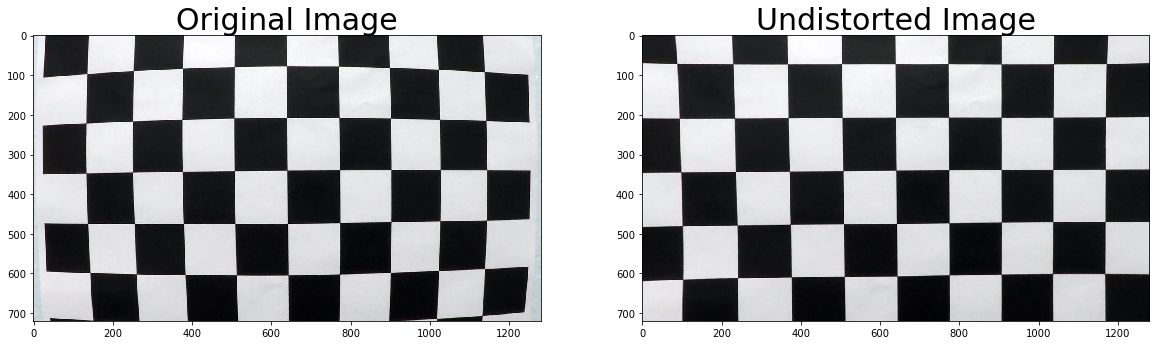

In [24]:
import pickle
%matplotlib inline

def undistort_image(fname):
    # Test undistortion on an image
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    return dst

undistorted_img = undistort_image("camera_cal/calibration1.jpg")


In [ ]:
### Perspective transform
